# Chainer-goghをためす
[画風を変換するアルゴリズム](https://research.preferred.jp/2015/09/chainer-gogh/)をためす。

### Chainer のインストール
```
$ sudo apt-get python3-
$ pip3 install chainer
```

### Chainer のバージョンの違いによる要変更部分

- caffe サブモジュールが function から links に変更されている

In [1]:
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
import numpy as np
import PIL.Image

model = VGG16Layers()
mean = [103.939, 116.779, 123.68]
categories = np.loadtxt("synset_words.txt",str,delimiter='\t')

In [2]:
#  NNのバッチ画像データを画像として返すメソッド
def toImage(nnimage,mean): 
    nnimage = (np.dstack(nnimage)+mean)[:,:,::-1]
    def clip(a):
        return 0 if a<0 else (255 if a>255 else a)
    nnimage = np.vectorize(clip)(nnimage)
    npimg = np.uint8(np.round(nnimage ))
    return PIL.Image.fromarray(np.uint8(npimg))

# 確率リストとしての出力からトップ５を出力するメソッド
def showtop5(prob): # prob は最終層から出力される確率リスト（Variable構造体)
    top5args = np.argsort(prob.data)[:-6:-1] # 上位５つの番号
    top5probs = prob.data[top5args] # 上位５つの確率
    for rank,(p,words) in enumerate(zip(top5probs,categories[top5args])):
        print(rank,translate(words))

In [3]:
# Google 翻訳サービスを使う
import requests
import re
 
url = 'https://translate.google.com/?hl=ja#en/ja/'

def translate(estring):
    r = requests.get(url, params={'q': estring})
 
    pattern = "TRANSLATED_TEXT=\'(.*?)\'"
    jstring = re.search(pattern, r.text).group(1)
 
    return jstring

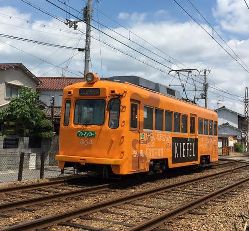

In [4]:
img = PIL.Image.open("train.jpg")
img.resize(np.array(img.size)//2)  # 画像の確認（ハーフサイスで表示している）

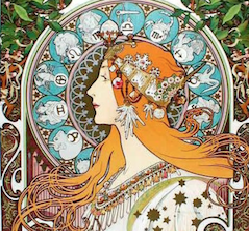

In [5]:
style= PIL.Image.open("Mucha.png")
style.resize(np.array(img.size)//2)  # 画像の確認（ハーフサイスで表示している）

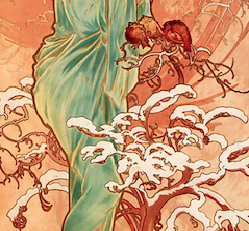

In [6]:
style2= PIL.Image.open("Mucha2.png")
style2.resize(np.array(img.size)//2)  # 画像の確認（ハーフサイスで表示している）

In [7]:
# データとスタイル画像２種の読み込み
npmodel = VGGprepare(img)
npstyle = VGGprepare(style)
npstyle2  = VGGprepare(style2)

In [8]:
# レイヤーの名前を表示
print(model.available_layers)

['conv1_1', 'conv1_2', 'pool1', 'conv2_1', 'conv2_2', 'pool2', 'conv3_1', 'conv3_2', 'conv3_3', 'pool3', 'conv4_1', 'conv4_2', 'conv4_3', 'pool4', 'conv5_1', 'conv5_2', 'conv5_3', 'pool5', 'fc6', 'fc7', 'fc8', 'prob']


In [9]:
predict = model.predict([img])[0]
showtop5(predict)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04487081トロリーバス、トロリーコーチ、トラックレストロリー


In [10]:
import os
import sys
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links
from chainer.links import caffe
# from chainer.functions import caffe
from chainer import Variable, optimizers
from io import BytesIO

from models import *  # models.py はこのフォルダにある

import pickle

from IPython.display import clear_output, Image, display

In [11]:
# チャネル間の相関行列
def ch_corr_matrix(y):
    print(y)
    ch = y.data.shape[1] # チャネル数
    wd = y.data.shape[2] # 幅（＝高さ）
    lines = F.reshape(y, (ch,wd**2)) # チャネルごとに１次元化
    matrix = F.matmul(lines, lines,transb=True) / np.float32(ch*wd**2) # 相関行列
    return matrix

# 画像生成 generate_image(nn, img, style_img1, style_img2, width, img_gen=None, max_iter=iter, lr=lr, of=outfolder)
def generate_image(nn, Oimg, Simg1, Simg2, width, img_gen=None,max_iter=100, lr=0.001, of="out"):
    # nn ニューラルネット
    # Oimg 対象画像
    # Simgスタイル画像
    # width 適用幅
 
    # ['conv1_1', 'conv1_2', 'pool1', 'conv2_1', 'conv2_2', 'pool2', 'conv3_1', 'conv3_2', 'conv3_3', 'pool3', 
    #   'conv4_1', 'conv4_2', 'conv4_3', 'pool4', 'conv5_1', 'conv5_2', 'conv5_3', 'pool5', 'fc6', 'fc7', 'fc8', 'prob']

    layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "vpool4"]
    layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

    global lam
    with chainer.no_backprop_mode():  # 　学習済みモデルで推論を実行したときのネットワークの変数の値を求める
    # with chainer.using_config('enable_backprop', False):　　# 逆伝搬しない
        origfeatures = nn.extract([Oimg], layers=layers_for_orig)
        stylefeatures1 = nn.extract([Simg1], layers=layers_for_style)
        stylefeatures2 = nn.extract([Simg2], layers=layers_for_style)     
 

        style_mats1 = [ch_corr_matrix(y) for y in stylefeatures1]
        style_mats2 = [ch_corr_matrix(y) for y in stylefeatures2]
 
    if img_gen is None:
        img_gen = np.random.uniform(-20,20,(1,3,width,width)).astype(np.float32)
        # imagePH = Variable(np.random.uniform(-20,20,(1,3,width,width)).astype(np.float32))

        # width x width の２次元カラー画像の変数を乱数で初期化
    img_gen = chainer.links.Parameter(img_gen)
    # imagePH = chainer.Parameter(imagePH)
    optimizer = optimizers.Adam(alpha=lr)
    optimizer.setup(img_gen)
 
    for i in range(max_iter):
        imagePH.zerograds()  # 微係数データをゼロに

        
        x = img_gen.W        # img_gen の重み係数をｘとして
        # x = imagePH
        y = nn.forward(x)    # nn で前向きに伝搬

        L = Variable(np.zeros((), dtype=np.float32))
        for l in range(len(y)):
            ch = y[l].data.shape[1]
            wd = y[l].data.shape[2]
            flat = F.reshape(y[l], (ch,wd**2)) # チャネルごとに 1次元化
            gogh_matrix = F.matmul(flat, flat, transb=True)/np.float32(ch*wd**2)
            
            L1 = lam * np.float32(nn.alpha[l])*F.mean_squared_error(y[l], Variable(mid_orig[l].data))
            L2 = np.float32(nn.beta[l])*F.mean_squared_error(gogh_matrix, Variable(style_mats[l].data))/np.float32(len(y))
            L += L1+L2
            
            if i%100==0:
                print(i,l,L1.data,L2.data)

        L.backward() # L を逆伝搬
        img_gen.W.grad = x.grad  # 入力層
        optimizer.update()
        
        tmp_shape = x.data.shape
        def clip(x):
            return -120 if x < -120 else (136 if x>136 else x)
        img_gen.W.data += np.vectorize(clip)(img_gen.W.data).reshape(tmp_shape) - img_gen.W.data
        # img_gen.W.data = np.vectorize(clip)(img_gen.W.data).reshape(tmp_shape)
        
        if i%50==0: 
            blobforshow = add_mean(img_gen.W.data,(120,120,120))
            display(save_image(blobforshow,i))    

# main 関数

In [12]:
description='A Neural Algorithm of Artistic Style'
orig = 'train.jpg' # 処理対象画像
style1 = 'Mucha.png' # スタイル画像1
style2 = 'Mucha2.png' # スタイル画像1
outfolder = 'outfolder' # 出力フォルダ
iter = 5000  # 繰り返し回数
lr = np.float32(4.0) # 学習係数
lam = np.float32(0.005) # 元画像/スタイル画像 比率
width = 227 # 画像幅


def main():

    try:
        os.mkdir(out_dir)  # 出力フォルダの作成
    except:
        pass

    img = PIL.Image.open(orig)
    style_img1 = PIL.Image.open(style1)
    style_img2 = PIL.Image.open(style2)
  
    nn = VGG16Layers()
    generate_image(nn, img, style_img1, style_img2, width, img_gen=None, max_iter=iter, lr=lr, of=outfolder)

In [13]:
main()


conv3_2


AttributeError: 'str' object has no attribute 'data'

In [ ]:
from chainer.links import VGG16Layers
model = VGG16Layers()

In [42]:
matrix = F.matmul(lines, lines,transb=True) / 3

NameError: name 'lines' is not defined

In [82]:
# チャネル間の相関行列
def ch_corr_matrix(y):
    ch = y.data.shape[1] # チャネル数
    wd = y.data.shape[2]
    lines = F.reshape(y, (ch,wd**2)) 
    matrix = F.matmul(lines, lines ,transb=True)/np.float(3)
    a = (ch*wd)
    return matrix


In [124]:
Oimg = PIL.Image.open(style1)
nn = VGG16Layers()
layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "vpool4"]
nn.extract([Oimg], layers=layers_for_orig)

{'conv4_1': variable([[[[    0.        ,     0.        ,     0.        , ...,
                239.3686676 ,     0.        ,     0.        ],
             [    0.        ,     0.        ,   282.0291748 , ...,
                361.51367188,   227.85675049,     0.        ],
             [    0.        ,     0.        ,     0.        , ...,
                  0.        ,     0.        ,     0.        ],
             ..., 
             [  728.14233398,   822.51177979,     0.        , ...,
                  0.        ,     0.        ,    77.99807739],
             [  469.73486328,   581.5916748 ,     0.        , ...,
                 57.89431381,     0.        ,   168.34475708],
             [    0.        ,     0.        ,     0.        , ...,
                  0.        ,     0.        ,     0.        ]],
 
            [[    0.        ,   825.57928467,  1108.08239746, ...,
                  0.        ,     0.        ,  1010.91479492],
             [    0.        ,     0.        ,  1072.51892